In [1]:
# Notebook for Testing
# https://signal.vercel.app/edit
# https://github.com/lolzone13/Markov-Music.git
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 2.8 MB/s eta 0:00:00


In [ ]:
!unzip kaggle.zip

In [2]:
import mido
from music21 import converter, instrument, note, chord, stream
from mido import MidiFile
import numpy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import string

In [ ]:
import pygame

pygame.init()
pygame.mixer.music.load(r'test_output.mid')
pygame.mixer.music.play()

# while pygame.mixer.music.get_busy():
#     pygame.time.wait(1000)
pygame.time.wait(10000)
pygame.mixer.music.stop()

In [ ]:
# https://github.com/Djadih/DataScience_Project


In [12]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [18]:

mid = mido.MidiFile('/content/kaggle/mozart/mz_311_1.mid', clip=True)
# mid.tracks[0]
midi_array = mid2arry(mid)


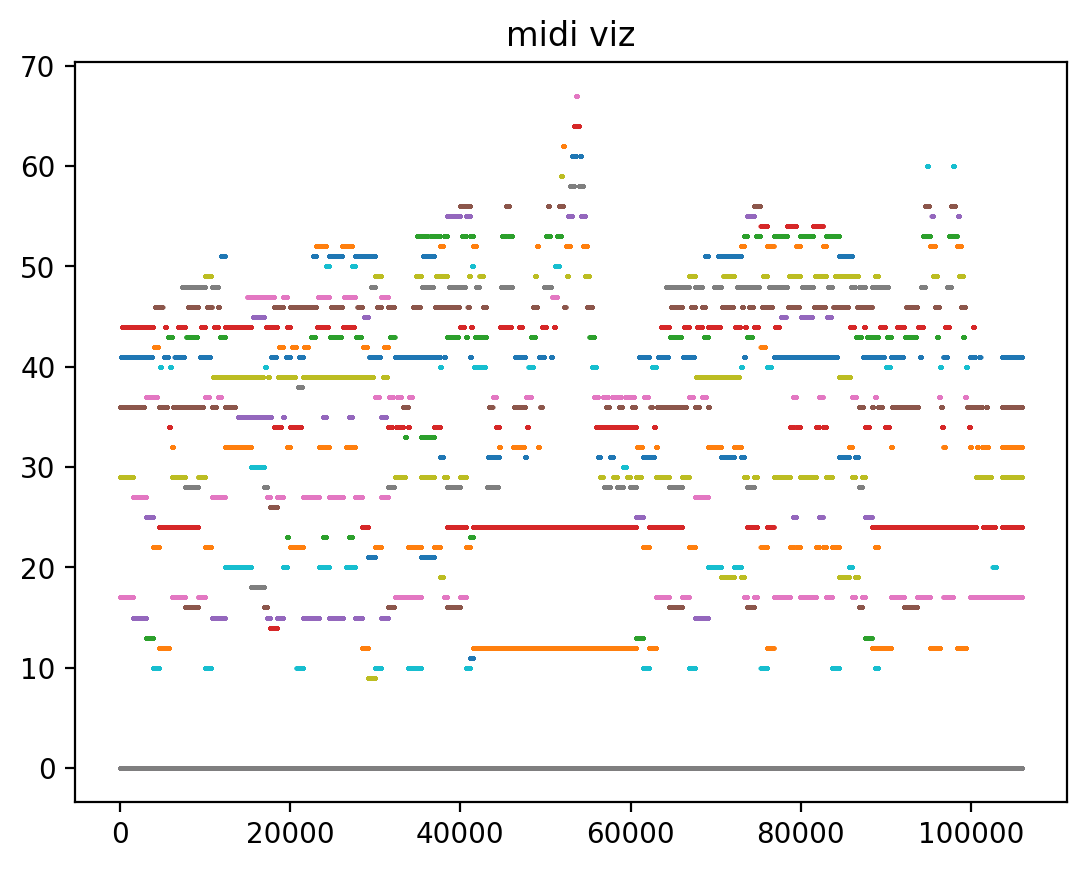

In [ ]:
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("midi viz")
plt.show()

In [17]:
midi_array.shape

(289439, 88)

In [19]:
def encode_vector_to_state(v):
  state = ""
  cnt = 1
  n = v.size
  for i in range(1,n):
    if v[i] == v[i-1]:
      cnt +=1
    else:
      state += str(v[i-1]) + 'x' + str(cnt) + '-'
      cnt = 1
  
  state += str(v[-1]) + 'x' + str(cnt)
  return state
  
# print(encode_vector(np.array([0,0,1,1,1,1,4,5,0,0,0,0,0,45,0,0,0,0])))

def decode_state_to_vector(state):
  v = []
  uniq = state.split('-')
  for el in uniq:
    num, cnt = el.split('x')
    v += [int(num)]*int(cnt)
  return np.array(v)

# print(decode_state_to_vector('0x2-1x4-4x1-5x1-0x5-45x1-0x4'))

In [20]:
uniq_midi_rows = np.unique(midi_array, axis=0)

In [23]:
print(uniq_midi_rows.shape)
print("uniq/total % = ", 100*uniq_midi_rows.shape[0]/midi_array.shape[0])
num_states = uniq_midi_rows.shape[0]

(1183, 88)
uniq/total % =  0.40872169956363863


In [24]:
states = [encode_vector_to_state(uniq_midi_rows[i]) for i in range(num_states)]
print(states[0:10])

['0x88', '0x65-44x1-0x22', '0x65-45x1-0x22', '0x65-47x1-0x22', '0x65-51x1-0x22', '0x65-55x1-0x22', '0x65-56x1-0x22', '0x65-57x1-0x22', '0x64-44x1-0x23', '0x64-45x1-0x23']


In [ ]:
# def state_to_idx(state, states):
#   return states.index(state)

In [31]:
# transition matrix
transition_prob = np.zeros((num_states, num_states))
# now fill it
for i in range(midi_array.shape[0]-1):
  curr_st = encode_vector_to_state(midi_array[i])
  next_st = encode_vector_to_state(midi_array[i+1])
  transition_prob[states.index(curr_st), states.index(next_st)] += 1

# now normalize to make it prob distri
epsilon = 1e-12
for i in range(num_states):
  sum = np.sum(transition_prob[i])
  transition_prob[i] = transition_prob[i]/(sum + epsilon)
  err = 1 - np.sum(transition_prob[i])
  transition_prob[i,0] += err



In [34]:
print(np.sum(transition_prob[0]))
print(transition_prob[0])

1.0
[8.21565038e-15 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [43]:
def random_walk(transition_prob, init_state = 0, WALK_LENGTH = 100000):
  '''
  returns seq. of index of states
  '''
  walk = []
  curr_st = init_state
  for i in range(WALK_LENGTH):
    walk.append(curr_st)
    next_st = np.random.choice(np.arange(num_states), p=transition_prob[curr_st])
    curr_st = next_st
  
  return np.array(walk) 


In [63]:
generated_midi_seq_idx = random_walk(transition_prob, 0)
print(generated_midi_seq_idx[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


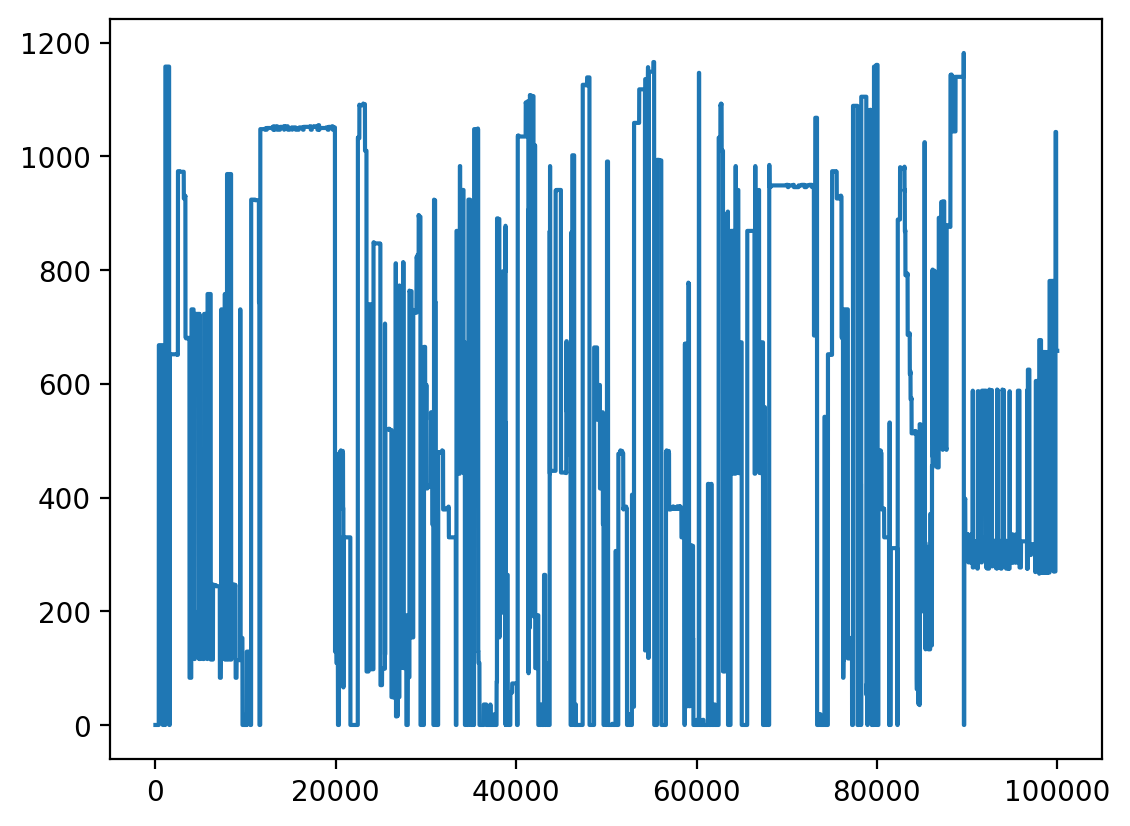

In [64]:
plt.plot(generated_midi_seq_idx)

In [65]:
generated_midi_array = np.zeros((generated_midi_seq_idx.size, 88))
i = 0
for idx in generated_midi_seq_idx:
  state = states[idx]
  vector = decode_state_to_vector(state).reshape(1,-1)
  generated_midi_array[i] = vector
  i += 1

generated_midi_array = generated_midi_array.astype('int')

In [66]:
# print(generated_midi_array.shape)
generated_midi_array[:4, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
mid.tracks[0]


In [68]:
# A tempo marking of 60 BPM equals one beat per second

mid_new = arry2mid(generated_midi_array, 500000)
mid_new.save('midi_gen3.mid')

In [69]:
'''
TODO:
write functions
try increase order
try softmax distri
play midi in colab
batch train 
HMM ?
'''

'\nTODO:\nwrite functions\ntry increase order\ntry softmax distri\nplay midi in colab\nbatch train \nHMM ?\n'

In [ ]:
def get_notes(filename):
    buffer_size = 5000
    notes = [''] * buffer_size
    Last_time = 0
    offset = []
    midi = converter.parse(filename)
    
    print('parsing {}'.format(filename))
    try:  # file has instrument parts
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.recurse()
    except:  # file has notes in a flat structure
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
      if isinstance(element, note.Note):    
         time = int(element.offset * 4)
        # print(element)
         if notes[time] == '':
            notes[time] = str(element.pitch.midi)
            last_time = time
      elif isinstance(element, chord.Chord):
         time = int(element.offset * 4)
         if notes[time] == '':
            notes[time] = '.'.join(str(n) for n in element.normalOrder)
            last_time = time
    return np.array(notes[:last_time])

notes = get_notes("/content/MoonlightSonata.mid")


parsing /content/MoonlightSonata.mid


In [ ]:
'''
In midi files, each Note has a distinct midi number ranging from 21 to 108
Dimension = n rows * 88 columns, each row contains the state of 88 notes at a particular time step. The notes out of piano keyboard range will be ignored.
The values in the array represent velocity (0 means note off, while (0:127] means note on).
'''

In [ ]:
for note in notes:
  print(note, end='-')

1-61-64--56-61-64--56-61-64--56-61-64--11-61-64--56-61-64--56-61-64--56-61-64--57-61-64--57-61-64--57-62-66--57-62-66--8-60-66--56-61-64--8-61-63--54-60-63--52-56-61--56-61-64--56-61-64--68-61-4.8--68-63-66--56-63-66--56-63-66--68-63-6.8--68-61-64--56-61-64--69-61-66--57-61-66--68-59-64--56-59-64--6.9-59-63--57-59-63--64-59-64--56-59-64--56-59-64--56-59-64--4-59-64--55-59-64--55-59-64--67-59-4.7--67-59-65--55-59-65--55-59-65--67-59-5.7--67-60-64--11-59-64--55-61-64--66-61-64--66-59-62--54-59-62--67-59-61--64-59-61--66-59-62--54-59-62--66-58-61--54-58-61--59-62-66--59-62-66--59-63-66--71-63-66--59-64-67--59-64-67--59-64-67--70-64-67--71-63-66--59-63-66--59-63-66--59-63-66--59-64-67--59-64-67--59-64-67--59-64-67--71-63-66--59-63-66--59-62-65--59-62-65--59-61-68--59-61-68--69-61-66--57-61-66--67-59-62---59-62--66-57-63---57-63--61-54-57---49-57--61-49-54--61-49-54--56-57-61--57-61-66--61-66-69--61-66-9.1--73-68-71--61-68-71--61-68-71--73-68-11.1--73-66-69--61-66-69--60-66-69--73-66-69--63

In [ ]:
print(np.unique(notes))

['' '1' '1.4.8' '11' '11.1' '3' '36' '37' '4' '4.7' '4.8' '40' '44' '48'
 '49' '5.7' '50' '51' '52' '54' '55' '56' '57' '58' '59' '6.8' '6.9' '60'
 '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '75'
 '76' '78' '79' '8' '8.11' '80' '81' '82' '84' '87' '9.1' '9.11']


In [ ]:
def prepare_sequences(notes, n_vocab, note_to_int):
   sequence_length = 400
   network_input = []
   network_output = []
   for i in range(0, len(notes) - sequence_length, 1):
      sequence_in = notes[i:i + sequence_length]
      sequence_out = notes[i + sequence_length]
      network_input.append([note_to_int[char] for char in sequence_in])
      network_output.append(note_to_int[sequence_out])
   n_patterns = len(network_input)
   normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
   normalized_input = normalized_input / float(n_vocab)
   # network_output = to_categorical(network_output)
   return (network_input, normalized_input, network_output)

In [ ]:
pitchnames = sorted(set(item for item in notes))  
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

network_input, normalized_input, network_output = prepare_sequences(notes, len(set(notes)), note_to_int)

In [ ]:
network_input = np.array(network_input)

In [ ]:
print(network_input.shape)

[[ 1 28 31 ... 33 36  0]
 [28 31  0 ... 36  0 30]
 [31  0 21 ...  0 30 33]
 ...
 [35  0 38 ...  0  0  0]
 [ 0 38 31 ...  0  0  0]
 [38 31 46 ...  0  0  0]]


In [ ]:
network_input

array([[15,  0,  0, ..., 59, 57, 59],
       [ 0,  0,  0, ..., 57, 59, 50],
       [ 0,  0,  0, ..., 59, 50, 45],
       ...,
       [67, 66, 67, ...,  0,  0, 27],
       [66, 67, 62, ...,  0, 27,  0],
       [67, 62, 67, ..., 27,  0,  0]])

In [ ]:
def make_markov_chain(seq):
  epsilon = 1e-9
  n = len(seq)
  transition_matrix = np.zeros((108,108))
  for i in range(1,n):
    transition_matrix[seq[i-1],seq[i]] += 1
  for i in range(108):
      transition_matrix[i] /= (np.sum(transition_matrix[i]) + epsilon)
      rem = 1 - np.sum(transition_matrix[i])
      transition_matrix[i][0] += rem
  
  return (transition_matrix)
    


In [ ]:
def random_walk(transition_matrix):
    generated_seq = []
    states = np.arange(0,108,1)
    f = 20
    generated_seq.append(f)
    for i in range(400):
        state = np.random.choice(states, p=transition_matrix[f])
        f = state
        generated_seq.append(f)
    return (generated_seq)


transition_matrix = make_markov_chain(network_input)
generated_sequence = random_walk(transition_matrix)


In [ ]:
transition_matrix[0:10,0:10]

array([[3.49968613e-02, 6.97495989e-03, 6.97495989e-03, 1.13517472e-02,
        1.87103299e-02, 6.10308991e-04, 6.97495989e-03, 6.97495989e-03,
        0.00000000e+00, 1.87626421e-02],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [4.67048711e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """

    output_notes = []

    # create note and chord objects based on the values generated by the model
    for idx, pattern in enumerate(prediction_output):
      if len(pattern) != 0:
        notes_in_chord = [int(n) for n in pattern.split('.')]
        new_chord = chord.Chord(notes_in_chord)
        new_chord.offset = idx/4
        output_notes.append(new_chord)
        # increase offset each iteration so that notes do not stack
    print(output_notes)
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='test_output.mid')

sequence_notes = []

for i in generated_sequence:   
   if i not in int_to_note:
      sequence_notes.append('')
   else:
      sequence_notes.append(int_to_note[i])

create_midi(sequence_notes)

[<music21.chord.Chord E F#>, <music21.chord.Chord E- F->, <music21.chord.Chord A5>, <music21.chord.Chord G5>, <music21.chord.Chord A5>, <music21.chord.Chord E4>, <music21.chord.Chord E2>, <music21.chord.Chord E4>, <music21.chord.Chord E2>, <music21.chord.Chord C#4>, <music21.chord.Chord F#5>, <music21.chord.Chord D4>, <music21.chord.Chord B4>, <music21.chord.Chord D5>, <music21.chord.Chord C5>, <music21.chord.Chord C5>, <music21.chord.Chord A5>, <music21.chord.Chord F#5>, <music21.chord.Chord C#5>, <music21.chord.Chord A B C#>, <music21.chord.Chord B5>, <music21.chord.Chord E4>, <music21.chord.Chord A5>, <music21.chord.Chord A5>, <music21.chord.Chord A5>, <music21.chord.Chord B5>, <music21.chord.Chord A5>, <music21.chord.Chord B5>, <music21.chord.Chord C#6>, <music21.chord.Chord D6>, <music21.chord.Chord E3>, <music21.chord.Chord F#3>, <music21.chord.Chord G3>, <music21.chord.Chord B3>, <music21.chord.Chord G3>, <music21.chord.Chord A3>, <music21.chord.Chord G4>, <music21.chord.Chord A